In [214]:
import earthnet_minicuber
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import folium
cmap_veg = clr.LinearSegmentedColormap.from_list('veg', ['#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529'])

In [4]:
# Hide warnings (many since some xarray class uses some deprecated python function on 3.9)
import warnings
warnings.filterwarnings('ignore')

In [5]:
specs = {
    "lon_lat": (43.598946, 3.087414), # center pixel
    "xy_shape": (512, 512), # width, height of cutout around center pixel
    "resolution": 30, # in meters.. will use this together with grid of primary provider..
    "time_interval": "2021-01-01/2021-02-01",
    "primary_provider": {
    "name": "s2",
    "kwargs": {"bands": ["B02", "B03", "B04"], "best_orbit_filter": True, "brdf_correction": True, "cloud_mask": True}
    },
    "other_providers": [
        {
            "name": "s1",
            "kwargs": {"bands": ["vv", "vh","mask"], "speckle_filter": True, "speckle_filter_kwargs": {"type": "lee", "size": 9}} 
        },
        {
            "name": "ndviclim",
            "kwargs": {"bands": ["mean", "std"]}
        },
        {
            "name": "srtm",
            "kwargs": {"bands": ["dem"]}
        },
        {
            "name": "esawc",
            "kwargs": {"bands": ["lc"]}
        }
        ]
}

In [6]:
cube = earthnet_minicuber.Minicuber.load_minicube(specs)

Requesting data: 100%|████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


In [7]:
cube

<xarray.Dataset>
Dimensions:        (time: 12, lat: 512, lon: 512, time_clim: 12)
Coordinates:
  * time           (time) datetime64[ns] 2021-01-02T07:38:57 ... 2021-02-01T0...
  * lon            (lon) float64 43.53 43.53 43.53 43.53 ... 43.67 43.67 43.67
  * lat            (lat) float64 3.157 3.157 3.156 3.156 ... 3.018 3.018 3.018
  * time_clim      (time_clim) datetime64[ns] 1970-01-15 ... 1970-12-15
Data variables:
    s2_mask        (time, lat, lon) float64 dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    s2_B02         (time, lat, lon) float32 dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    s2_B03         (time, lat, lon) float32 dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    s2_B04         (time, lat, lon) float32 dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    s1_mask        (time, lat, lon) float32 dask.array<chunksize=(3, 512, 512), meta=np.ndarray>
    s1_vv          (time, lat, lon) float32 dask.array<chunksize=(3, 512, 512), meta=np.ndarray>
    s1_vh          (time, lat, lon) float32 dask.array<chunksize=(3, 512, 512), meta=np.ndarray>
    ndviclim_mean  (time_clim, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    ndviclim_std   (time_clim, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    srtm_dem       (lat, lon) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    esawc_lc       (lat, lon) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>

In [170]:
def map(minicube):
    x_min, x_max, y_min, y_max = minicube.lon[0].values, minicube.lon[-1].values, minicube.lat[-1].values, minicube.lat[0].values
    # Create map
    interactive_map = folium.Map(
        location=((y_min+y_max)/2, (x_min+x_max)/2),
        zoom_start=min(int((np.log(1000 / (x_max-x_min)) / np.log(2))), int((np.log(1000 / (y_max-y_min)) / np.log(2)))),
        tiles="http://mt1.google.com/vt/lyrs=y&z={z}&x={x}&y={y}",
        attr="Google",
    )

    # Create bounding box coordinates to overlay on map
    line_segments = [
        (y_min, x_min),
        (y_min, x_max),
        (y_max, x_max),
        (y_max, x_min),
        (y_min, x_min),
    ]

    # Add bounding box as an overlay
    interactive_map.add_child(
        folium.features.PolyLine(locations=line_segments, color="red", opacity=0.8)
    )
    #folium.PolyLine(locations=line_segments, color="red", opacity=0.8).add_to(interactive_map)
    
    return interactive_map

# Folium plot

In [222]:
# HPARAMS
t = 0

In [223]:
rgb = cube[["s2_B04", "s2_B03", "s2_B02"]].to_array("band").isel(time = t).to_numpy()
rgb = np.nan_to_num(rgb, nan=0.0)
rgb = np.swapaxes(rgb, 0, 2)
rgb = np.swapaxes(rgb, 0, 1)

In [224]:
srtm = cube.srtm_dem.to_numpy()
srtm = np.nan_to_num(srtm, nan=0.0)

In [229]:
mask = cube["s2_mask"].isel(time=t).where(lambda x: x>0).to_numpy()
mask = np.nan_to_num(mask, nan=0.0)

In [255]:
interactive_map = map(cube)

bounds = [[float(cube.lat[-1].values), float(cube.lon[0].values)], [float(cube.lat[0].values), float(cube.lon[-1].values)]]

# Add RGB layer
folium.raster_layers.ImageOverlay(
    image=rgb,
    bounds=bounds,
    mercator_project=True,
    name="Sentinel 2 RGB",
    opacity=0.95,
).add_to(interactive_map)

# Add cloud layer
folium.raster_layers.ImageOverlay(
    image=mask,
    bounds=bounds,
    mercator_project=True,
    name="S2 Mask",
    colormap = lambda x: (1, x/10, -x/2, x),
).add_to(interactive_map)

# Add SRTM
folium.raster_layers.ImageOverlay(
    image=srtm,
    bounds=bounds,
    mercator_project=True,
    name="SRTM",
    opacity=0.9,
    show=False,
).add_to(interactive_map)

folium.map.LayerControl(position='topright', collapsed=False, autoZIndex=True).add_to(interactive_map)

interactive_map

# Other Plots

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


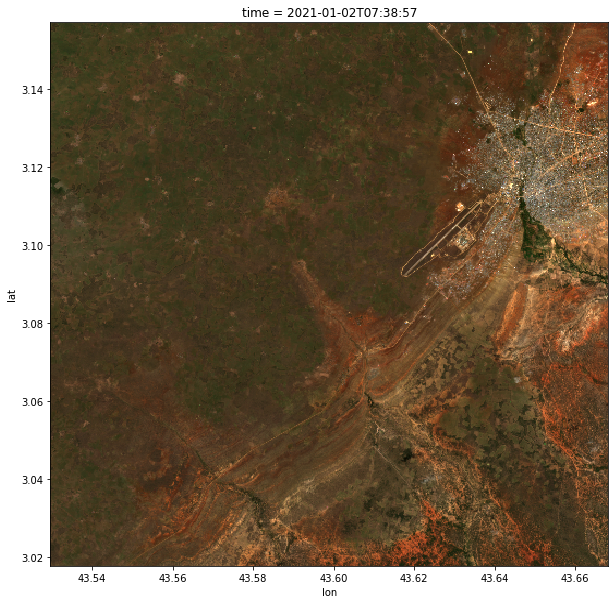

In [216]:
rgb_brightness_scaling=3

(cube[["s2_B04", "s2_B03", "s2_B02"]].to_array("band").isel(time = 0) * rgb_brightness_scaling).plot.imshow(rgb="band", figsize = (10, 10))

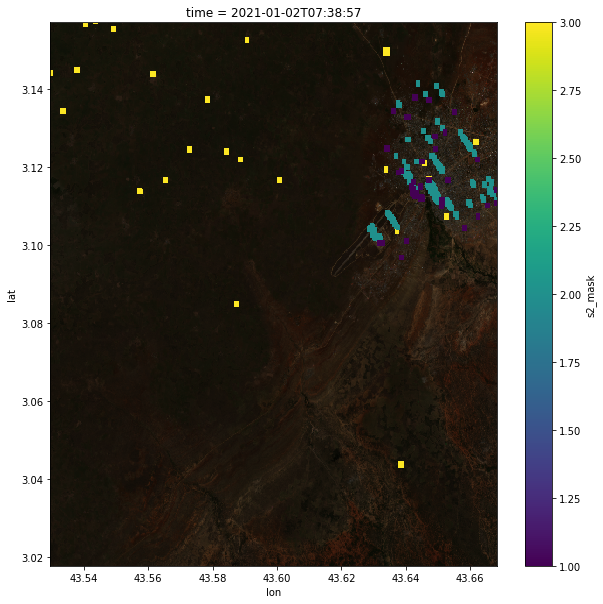

In [250]:
(cube[["s2_B04", "s2_B03", "s2_B02"]].to_array("band").isel(time = 0)).plot.imshow(rgb="band", figsize=(12,10))
cube["s2_mask"].isel(time=0).where(lambda x: x>0).plot.imshow(ax = plt.gca())

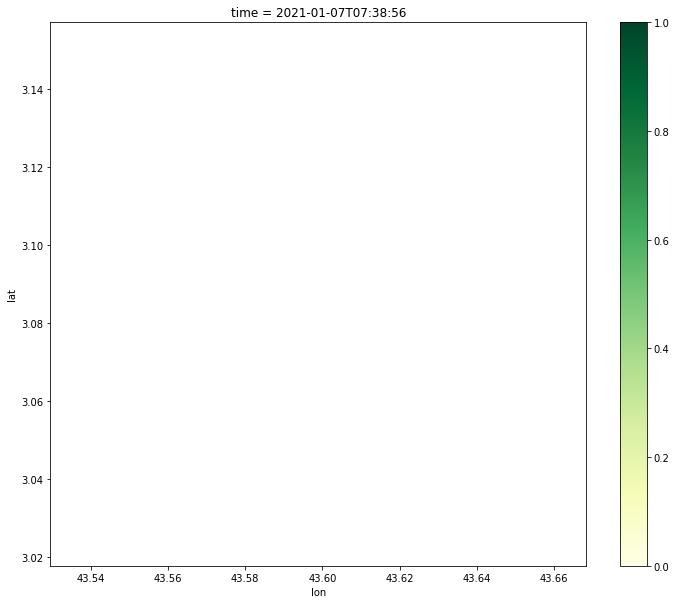

In [251]:
(4 * cube.s1_vh / (cube.s1_vh + cube.s1_vv)).isel(time=2).plot.imshow(vmin = 0, vmax = 1,cmap = cmap_veg, figsize = (12, 10))

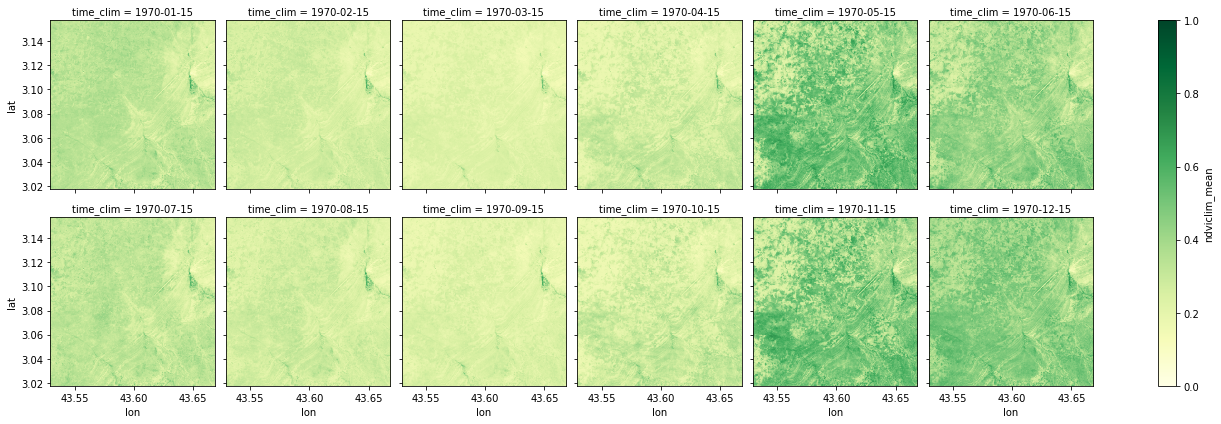

In [252]:
cube.ndviclim_mean.plot.imshow(col = "time_clim", col_wrap = 6, cmap = cmap_veg, vmin = 0, vmax = 1)

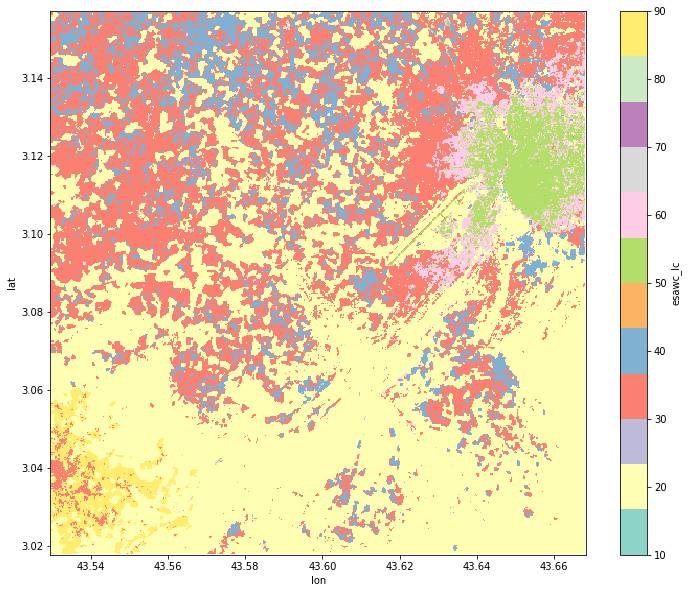

In [253]:
cube.esawc_lc.plot(cmap="Set3", figsize = (12, 10))

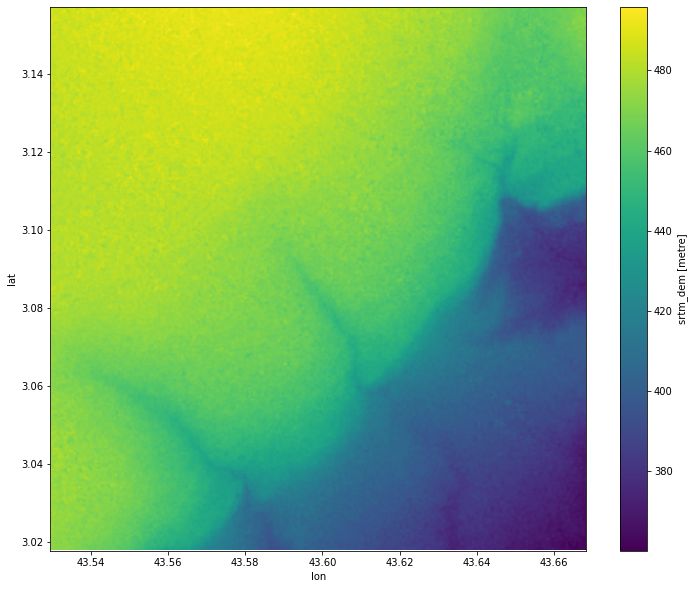

In [254]:
cube.srtm_dem.plot.imshow(figsize = (12, 10))